## Outlier Detection & Removal (High Level)
- Check initial distribution
- Check quantile ranges and remove outlier
- Plot the distribution, to check before and after

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count, avg, sum, date_format
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/11 19:45:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/11 19:45:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# load data from ETL
df_trx_sa2 = spark.read.parquet('../data/curated/df_trx_sa2.parquet')
df_trx_sa2_test = spark.read.parquet('../data/curated/df_trx_sa2_test.parquet')

---
### Initial revenue distribution

In [4]:
pd_df_train = df_trx_sa2.toPandas()
pd_df_test = df_trx_sa2_test.toPandas()

In [5]:
pd_df_train.isna().sum()

merchant_abn         0
user_id              0
consumer_id          0
gender               0
dollar_value         0
order_id             0
order_datetime       0
sa2_maincode_2016    0
categories           0
revenue_level        0
take_rate            0
revenue              0
dtype: int64

In [6]:
pd_df_test.isna().sum()

merchant_abn         0
user_id              0
consumer_id          0
gender               0
dollar_value         0
order_id             0
order_datetime       0
sa2_maincode_2016    0
categories           0
revenue_level        0
take_rate            0
revenue              0
dtype: int64

In [7]:
from datetime import date
pd_df_train = pd_df_train[(pd_df_train['order_datetime'] >= date(2021,2,8)) 
                          & (pd_df_train['order_datetime'] <= date(2022,2,27))]
pd_df_test = pd_df_test[(pd_df_test['order_datetime'] >= date(2022,2,28)) 
                          & (pd_df_test['order_datetime'] <= date(2022,8,28))]

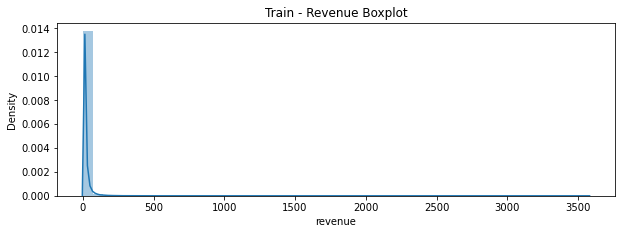

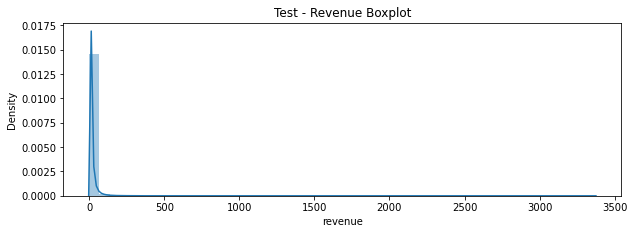

In [12]:
plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 1)
sns.distplot((pd_df_train)['revenue'])
plt.title("Train - Revenue Boxplot")
plt.savefig(f'../plots/train_initial_distribution.png',bbox_inches='tight')

plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 2)
sns.distplot((pd_df_test)['revenue'])
plt.title("Test - Revenue Boxplot")
plt.savefig(f'../plots/test_initial_distribution.png',bbox_inches='tight')

---
### Quartile ranges checking

In [9]:
def print_quantile_ranges(df_series, min_q, max_q, step):
    '''
    Print the quantile value of 'df_series' from 'min_q' to 'max_q' by 'step'
    '''
    curr_q = min_q
    run = max_q // step
    
    i = 0
    while curr_q < 1:
        qt = df_series.quantile(curr_q)
        print(f"{round(curr_q, 3)} Quantile:\t{qt}")
        curr_q += step
        i += 1
    

In [10]:
for catg in pd_df_train['categories'].unique():
    tr_series_catg = pd_df_train[pd_df_train['categories'] == catg]['revenue']
    te_series_catg = pd_df_test[pd_df_test['categories'] == catg]['revenue']
    print(f'{catg}')
    print(f'\nTrain {catg} - Quantile ranges from 0-100th')
    print_quantile_ranges(tr_series_catg,0,1,0.1)
    
    print(f'\nTrain {catg} - Quantile ranges from 90-100th')
    print_quantile_ranges(tr_series_catg,0.9,1,0.01)
    
    print(f'\nTrain {catg} - Quantile ranges from 99-100th')
    print_quantile_ranges(tr_series_catg,0.99,1,0.001)
    
    print('..'*25)
    print(f'\nTest {catg} - Quantile ranges from 0-100th')
    print_quantile_ranges(te_series_catg,0,1,0.1)
    
    print(f'\nTest {catg} - Quantile ranges from 90-100th')
    print_quantile_ranges(te_series_catg,0.9,1,0.01)

    print(f'\nTest {catg} - Quantile ranges from 99-100th')
    print_quantile_ranges(te_series_catg,0.99,1.001,0.001)
    
    print('__'*25)

gift, card, novelty, and souvenir shops

Train gift, card, novelty, and souvenir shops - Quantile ranges from 0-100th
0 Quantile:	0.38428792357444763
0.1 Quantile:	1.6048430681228638
0.2 Quantile:	2.4236123085021974
0.3 Quantile:	2.9769829988479617
0.4 Quantile:	3.5172045230865483
0.5 Quantile:	4.124618053436279
0.6 Quantile:	4.821007347106933
0.7 Quantile:	5.709615707397461
0.8 Quantile:	6.829618644714356
0.9 Quantile:	8.7228401184082
1.0 Quantile:	44.81547164823519

Train gift, card, novelty, and souvenir shops - Quantile ranges from 90-100th
0.9 Quantile:	8.722840118408204
0.91 Quantile:	8.997188682556153
0.92 Quantile:	9.287026023864746
0.93 Quantile:	9.60416244506836
0.94 Quantile:	10.028988742828368
0.95 Quantile:	10.571699953079222
0.96 Quantile:	11.243080291748049
0.97 Quantile:	12.098330755233775
0.98 Quantile:	13.276509914398222
0.99 Quantile:	15.346915283203145

Train gift, card, novelty, and souvenir shops - Quantile ranges from 99-100th
0.99 Quantile:	15.346915283203124
0.

In [10]:
def remove_outlier_tags_IQR(df):
    """ Function to implement outlier removal
    Args : 
    - df : transaction dataframe
    Returns :
    - df_final : output dataframe after outlier removal
    - first 5 categories distplot
    """

    df_final = pd.DataFrame()   # Initialize empty dataframe
    categories = df["categories"].unique()

    i = 0
    
    for category in categories:
        category_df = df[df['categories'] == category]
        
        if i < 5:
            # Show Initial Revenue Distribution plot per category
            fig = plt.figure(figsize =(10, 7))
            sns.distplot(category_df['revenue'])
            plt.title(f'Before - {category}')
            plt.savefig(f'../plots/{i}_before_distribution.png')

        # Calculate IQR per category to Remove Outliers
        qt = category_df['revenue'].quantile(0.99)
        category_df_final = category_df[(category_df['revenue'] < qt)]
        
        if i < 5:
            # Show Revenue Distribution plot per category after Outlier Removal
            fig = plt.figure(figsize =(10, 7))
            sns.distplot(category_df_final['revenue'])
            plt.title(f'After - {category}')
            plt.savefig(f'../plots/{i}_after_distribution.png')

        df_final = df_final.append(category_df_final) # Append Category Dataframe with Outliers Removed to Final dataframe
         
        i += 1
    return df_final

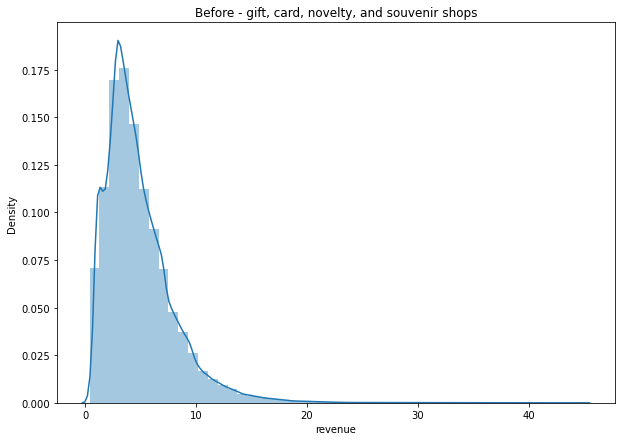

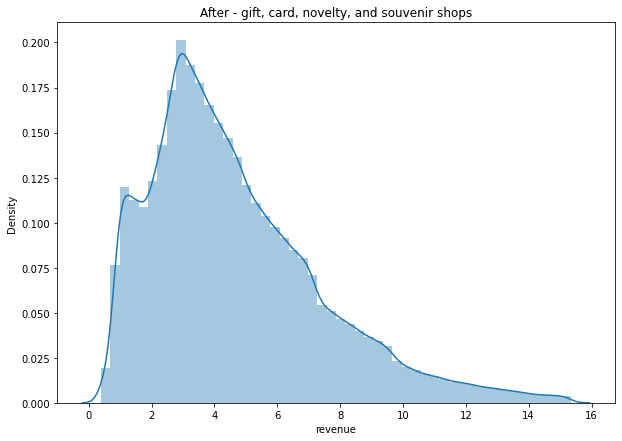

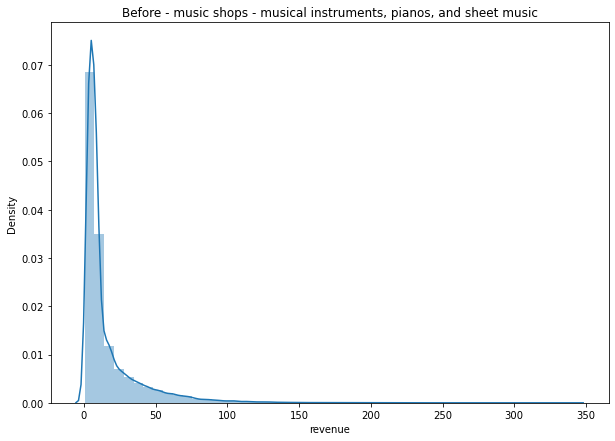

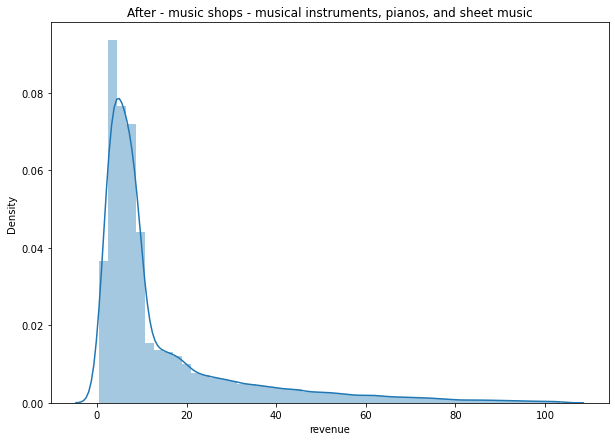

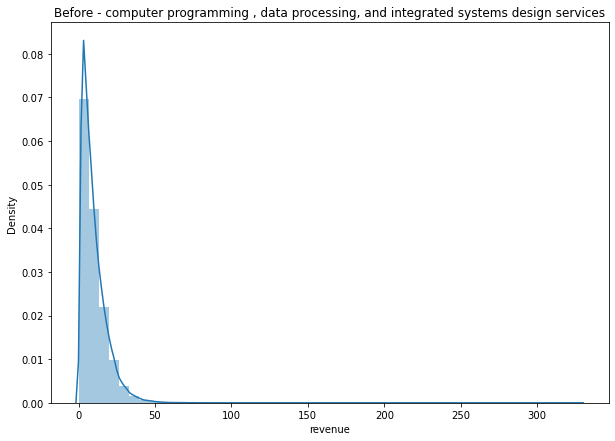

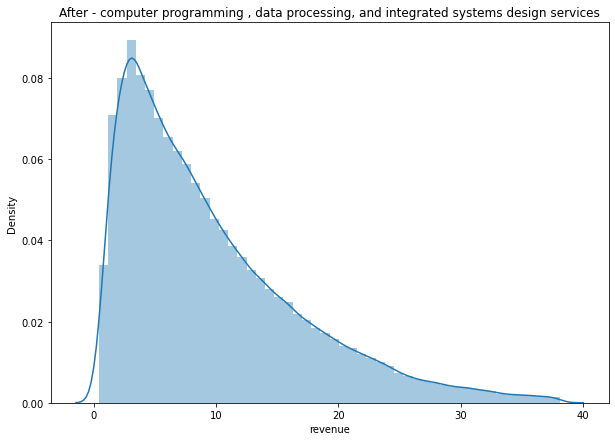

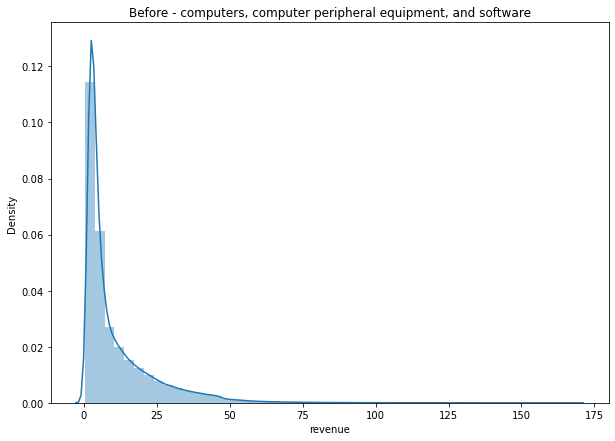

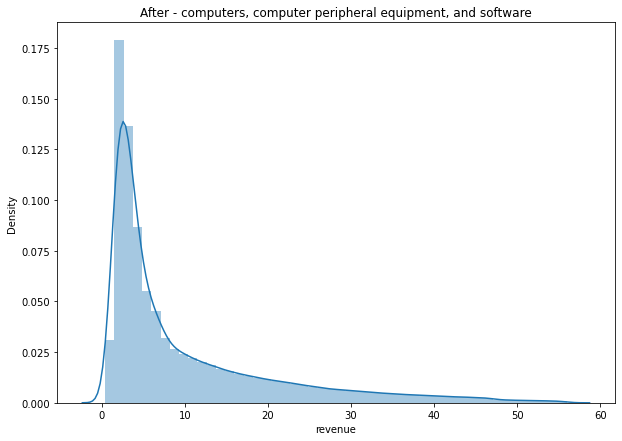

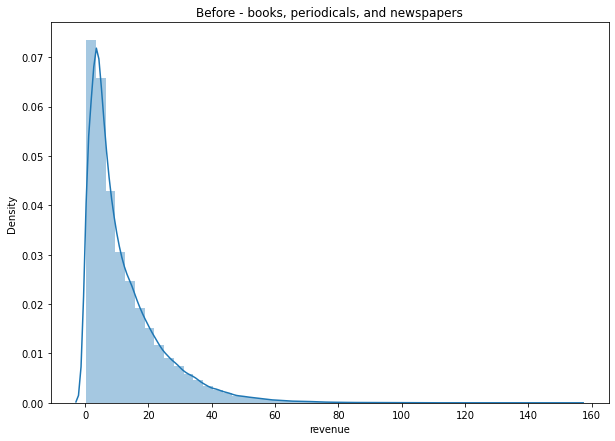

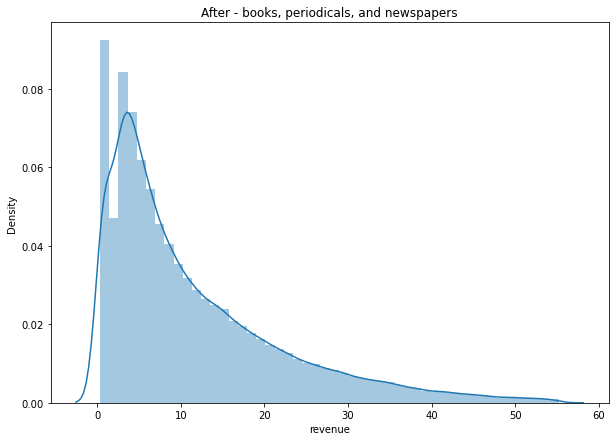

In [11]:
df_train = remove_outlier_tags_IQR(pd_df_train)

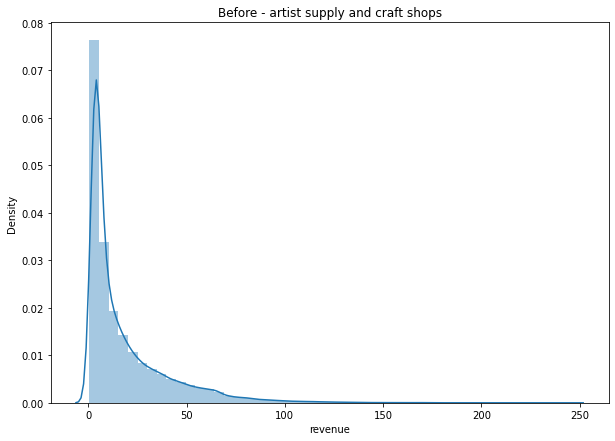

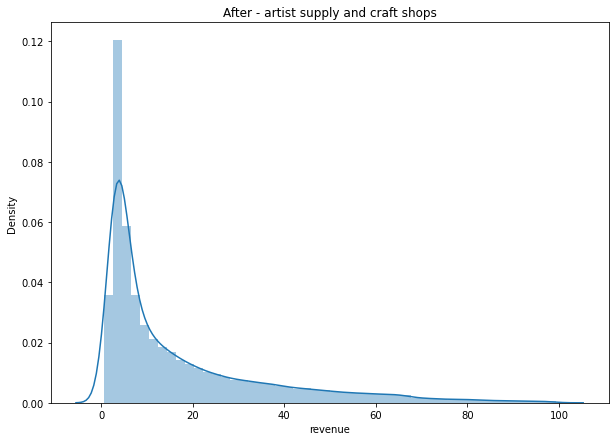

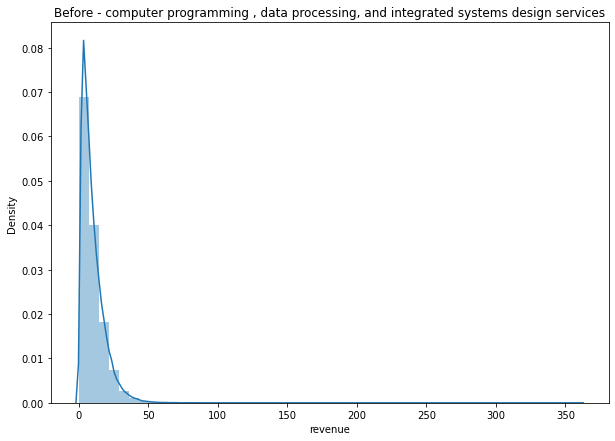

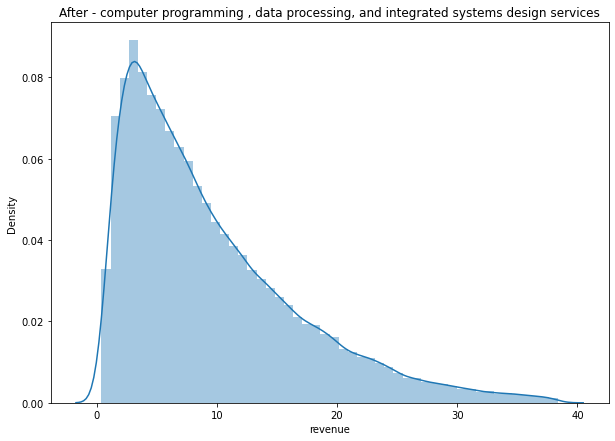

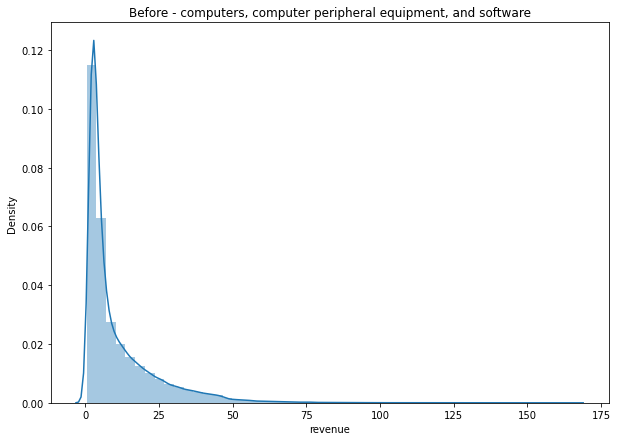

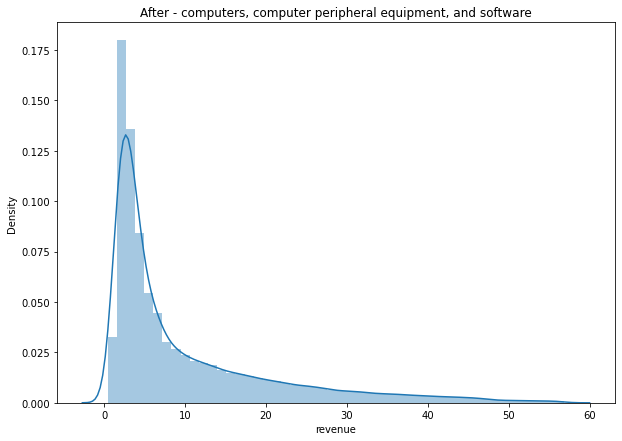

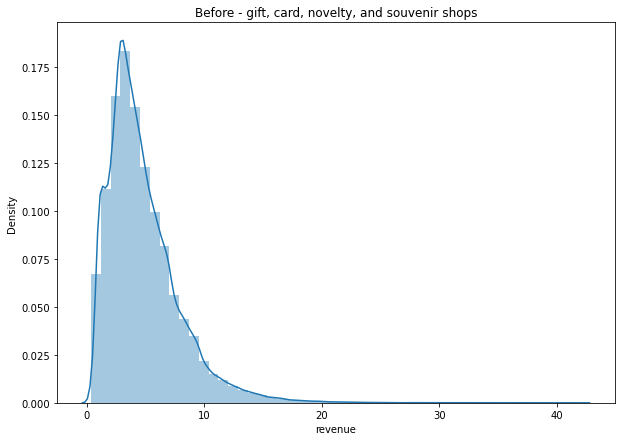

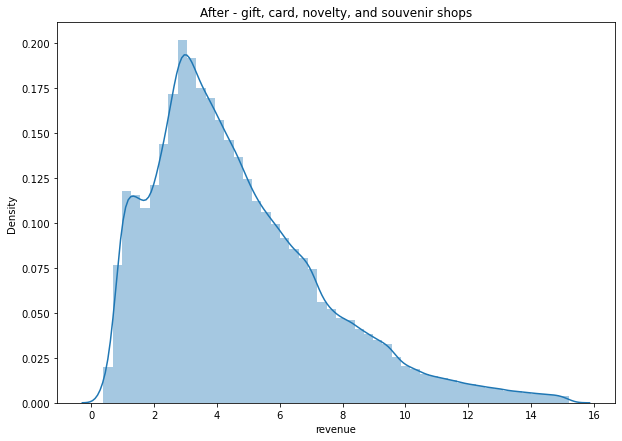

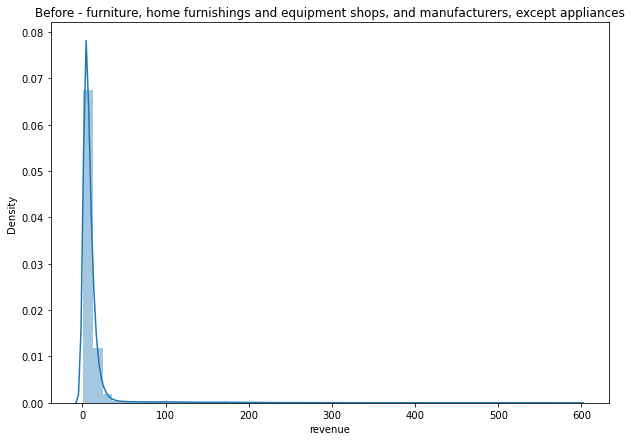

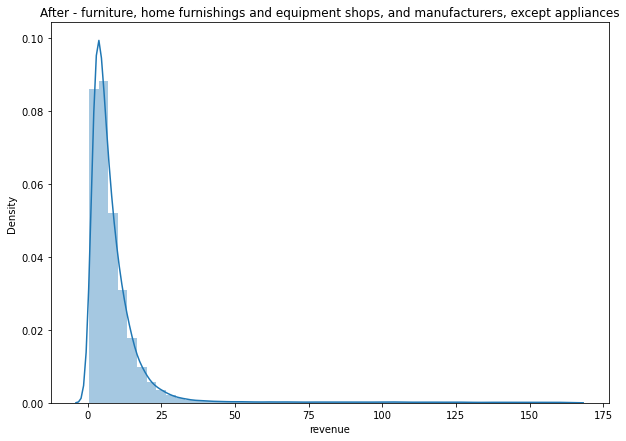

In [13]:
df_test = remove_outlier_tags_IQR(pd_df_test)

In [14]:
print("Train dataframe size before:", len(pd_df_train))
print("Test dataframe size before:", len(pd_df_test))

print("\nTrain dataframe size after:", len(df_train))
print("Test dataframe size after:", len(df_test))

Train dataframe size before: 4368706
Test dataframe size before: 2361542

Train dataframe size after: 4325008
Test dataframe size after: 2337914


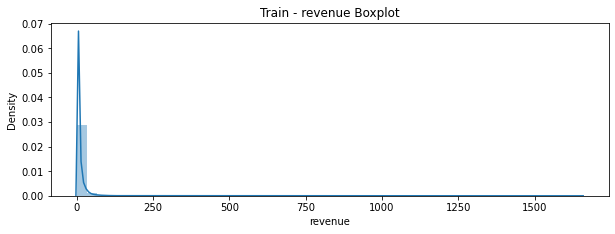

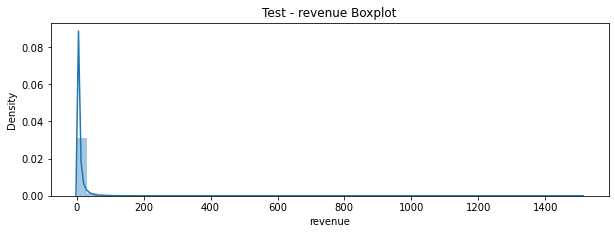

In [16]:
plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 1)
sns.distplot((df_train)['revenue'])
plt.title("Train - revenue Boxplot")
plt.show()

plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 2)
sns.distplot((df_test)['revenue'])
plt.title("Test - revenue Boxplot")
plt.show()

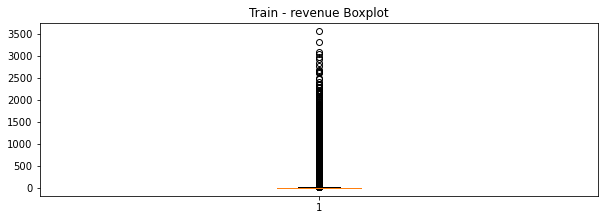

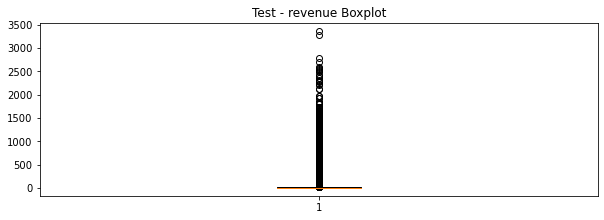

In [17]:
plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 1)
plt.boxplot((pd_df_train)['revenue'])
plt.title("Train - revenue Boxplot")
plt.show()

plt.figure(figsize =(10, 7))
plt.subplot(2, 1, 2)
plt.boxplot((pd_df_test)['revenue'])
plt.title("Test - revenue Boxplot")
plt.show()

---
### Save final dataframes

In [18]:
df_train.to_parquet("../data/curated/clean_df_trx_sa2.parquet")
print("Successfully save clean_df_trx_sa2")

df_test.to_parquet("../data/curated/clean_df_trx_sa2_test.parquet")
print("Successfully save clean_df_trx_sa2_test")

Successfully save clean_df_trx_sa2
Successfully save clean_df_trx_sa2_test
